In [1]:
import json
import random
import sys

import numpy as np

sys.path.insert(1, '../../src')

from ce.algorithms.greedy_heuristics import random_solution
from ce.algorithms.local_search import two_edges_neighborhood
from ce.algorithms.local_search.local_search_cache import steepest_local_search_cache
from ce.tsp import create_tsp, TSP
from ce.utils.experiments import quality_plots
from ce.algorithms.evolutionary import evolution

# Hybrid evolutionary algorithm

**Nina Zukowska 148278, Antoni Solarski 148270**

In [2]:
problem_instance_A_path = '../../data/TSPA.csv'
problem_instance_B_path = '../../data/TSPB.csv'
problem_instance_C_path = '../../data/TSPC.csv'
problem_instance_D_path = '../../data/TSPD.csv'

In [3]:
tspa = create_tsp(problem_instance_A_path)
tspb = create_tsp(problem_instance_B_path)
tspc = create_tsp(problem_instance_C_path)
tspd = create_tsp(problem_instance_D_path)

## Algorithms

---

#### Selection
Parents are selected randomly with uniform distribution.

```python
def select_parents(population):
    return random.sample(population, 2)
```

#### Crossover
The half of the first parent is copied into the offspring, then all nodes from this half are removed from second parent.
From the second parent (with removed nodes) first 50 nodes are used as second half of the offspring.

```python
def crossover(parent1, parent2):
    return parent1[:50] + [p for p in parent2 if p not in set(parent1[:50])][:50]
```

---

#### Evolutionary algorithm
Steady state algorithm is used, only elite (best so far) solutions are kept.
Offspring is improved with the usage of steepest local search (this can be treated as offspring growing up).

```python
def evolution(tsp, initial_population, local_search_fn, time_limit):
    population = [local_search_fn(tsp, x)[0] for x in initial_population]
    population = SortedDict({tsp.get_solution_cost(x): x for x in population})

    iterations, iterations_with_improvements, start_time = 0, 0, time.time()
    while time.time() - start_time < time_limit:
        parents = select_parents(population.values())
        offspring = crossover(*parents)
        offspring = local_search_fn(tsp, offspring)[0]
        offspring_cost = tsp.get_solution_cost(offspring)
        if offspring_cost < population.keys()[-1] and offspring_cost not in population:
            del population.keys()[-1]
            population[offspring_cost] = offspring
            iterations_with_improvements += 1
        iterations += 1

    return population, iterations, iterations_with_improvements
```

---

## Experiments

In [4]:
time_limit = 1800  # 30 minutes
population_size = 20
experiments = ["multiple start local search", "iterated local search", "large scale (with ls)", "evolutionary"]

In [5]:
def load_previous_results(instance):
    previous_results, previous_best_solutions = [], []
    with open(f'../report_6/results_{instance}.json', 'r', encoding='utf-8') as f:
        previous_results += json.load(f)
    with open(f'../report_7/results_{instance}.json', 'r', encoding='utf-8') as f:
        previous_results += [json.load(f)[1]]
    with open(f'../report_6/best_solutions_{instance}.json', 'r', encoding='utf-8') as f:
        previous_best_solutions += json.load(f)
    with open(f'../report_7/best_solutions_{instance}.json', 'r', encoding='utf-8') as f:
        previous_best_solutions += [json.load(f)[1]]
    return previous_results, previous_best_solutions

In [6]:
def get_initial_population(tsp: TSP, k: int):
    return [random_solution(tsp) for _ in range(k)]

In [7]:
def local_search_fn(tsp: TSP, x):
    return steepest_local_search_cache(tsp, x, two_edges_neighborhood)

In [8]:
def experiment(tsp: TSP, k: int, time_limit: float):
    initial_population = get_initial_population(tsp, k)
    population, iterations, iterations_with_improvement = evolution(tsp, initial_population, local_search_fn, time_limit)
    results_cost = population.keys()
    print(f'cost: {sum(results_cost) / len(results_cost):0.1f}, ({min(results_cost):0.0f} - {max(results_cost):0.0f})')
    print(f'iterations: {iterations}, iterations with improvement: {iterations_with_improvement}, ratio: {iterations_with_improvement / iterations}')
    return population

---

### Instance C

In [9]:
%%time
random.seed(23)
np.random.seed(23)

print("**********************************************************************************************************************")
c_population = experiment(tspc, population_size, time_limit)
print("**********************************************************************************************************************")

**********************************************************************************************************************
cost: 48045.6, (47915 - 48104)
iterations: 57466, iterations with improvement: 262, ratio: 0.004559217624334389
**********************************************************************************************************************
CPU times: total: 30min 9s
Wall time: 30min 9s


In [10]:
c_results, c_best_solution = [list(c_population.keys())], [c_population.values()[0]]

In [11]:
c_previous_results, c_previous_best_solutions = load_previous_results('c')

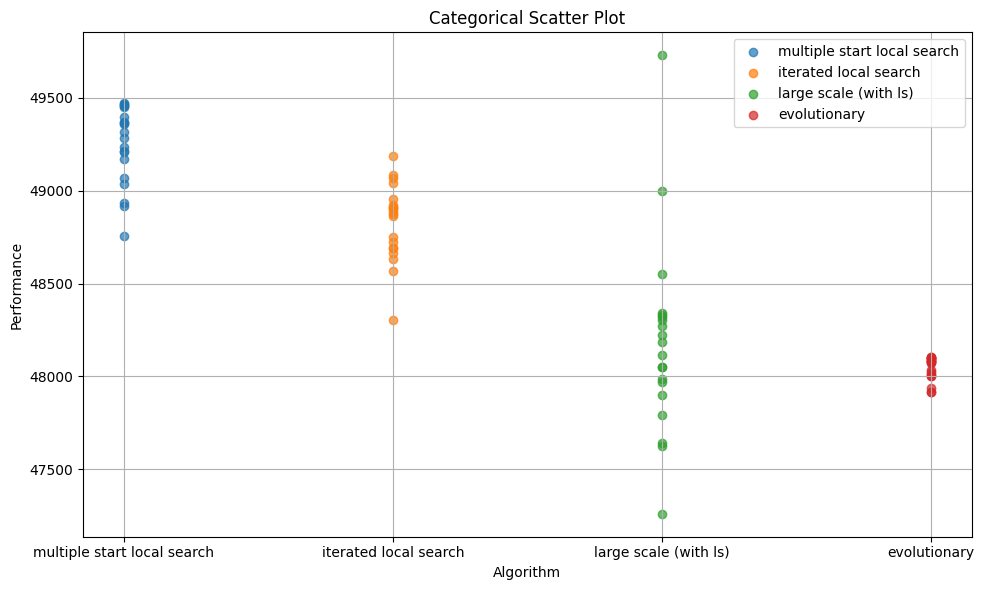

In [12]:
quality_plots(c_previous_results + c_results, categories=experiments)

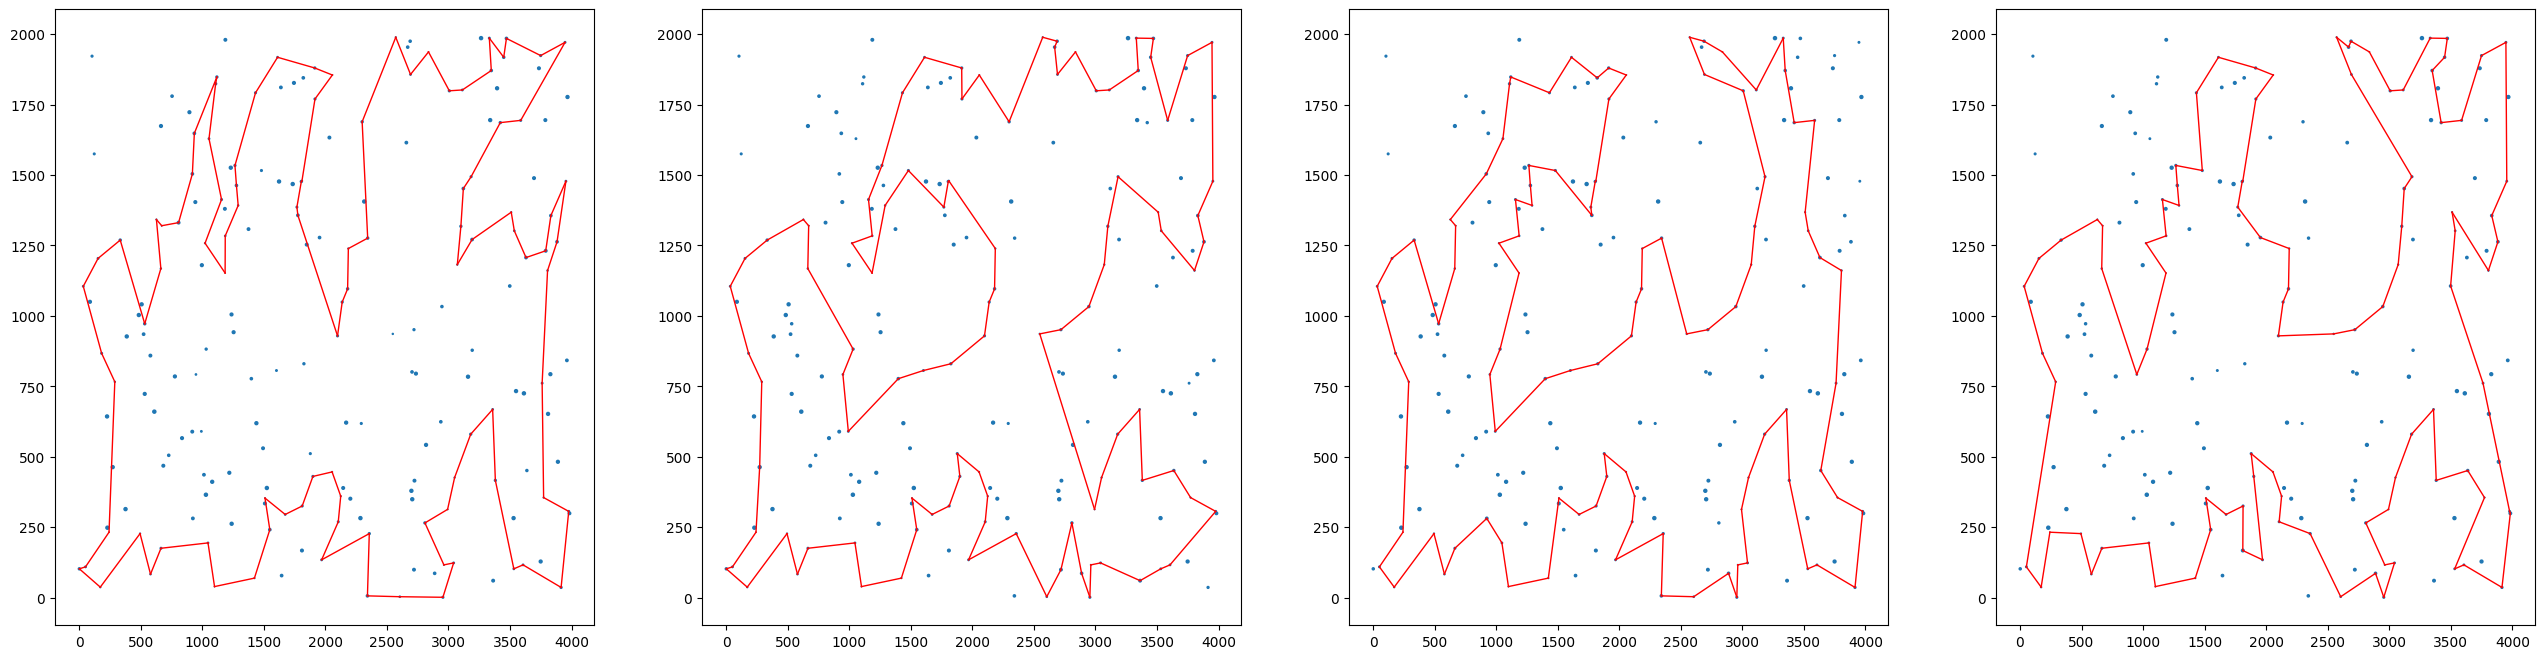

In [13]:
tspc.plot(c_previous_best_solutions + c_best_solution)

In [14]:
with open('results_c.json', 'w', encoding='utf-8') as f:
    json.dump(c_results, f, ensure_ascii=False, indent=4)
with open('best_solutions_c.json', 'w', encoding='utf-8') as f:
    json.dump(c_best_solution, f, ensure_ascii=False, indent=4)

---

### Instance D

In [15]:
%%time
random.seed(23)
np.random.seed(23)

print("**********************************************************************************************************************")
d_population = experiment(tspd, population_size, time_limit)
print("**********************************************************************************************************************")

**********************************************************************************************************************
cost: 44100.3, (43872 - 44196)
iterations: 45914, iterations with improvement: 211, ratio: 0.004595548198806464
**********************************************************************************************************************
CPU times: total: 30min 9s
Wall time: 30min 9s


In [16]:
d_results, d_best_solution = [list(d_population.keys())], [d_population.values()[0]]

In [17]:
d_previous_results, d_previous_best_solutions = load_previous_results('d')

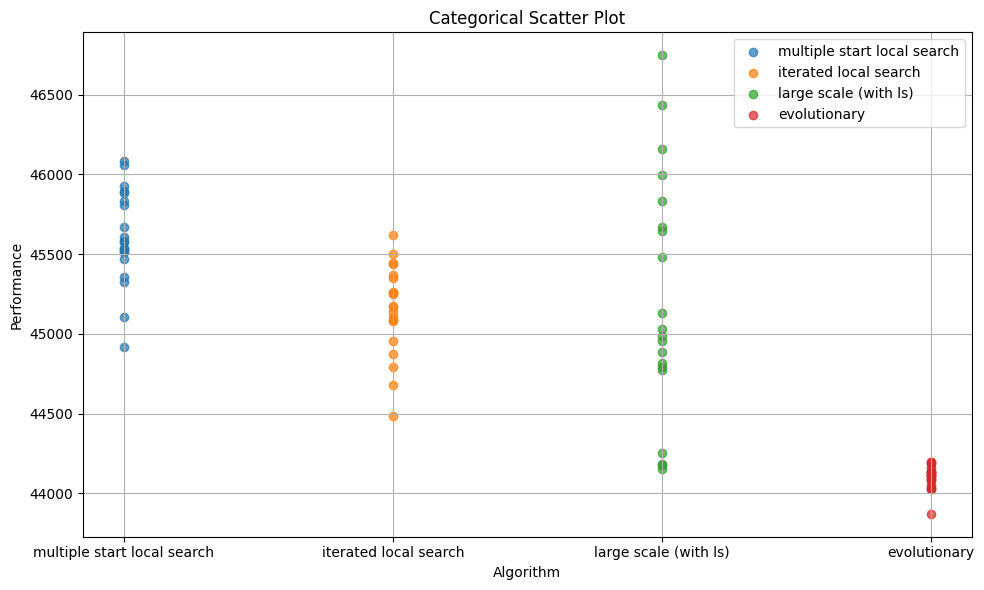

In [18]:
quality_plots(d_previous_results + d_results, categories=experiments)

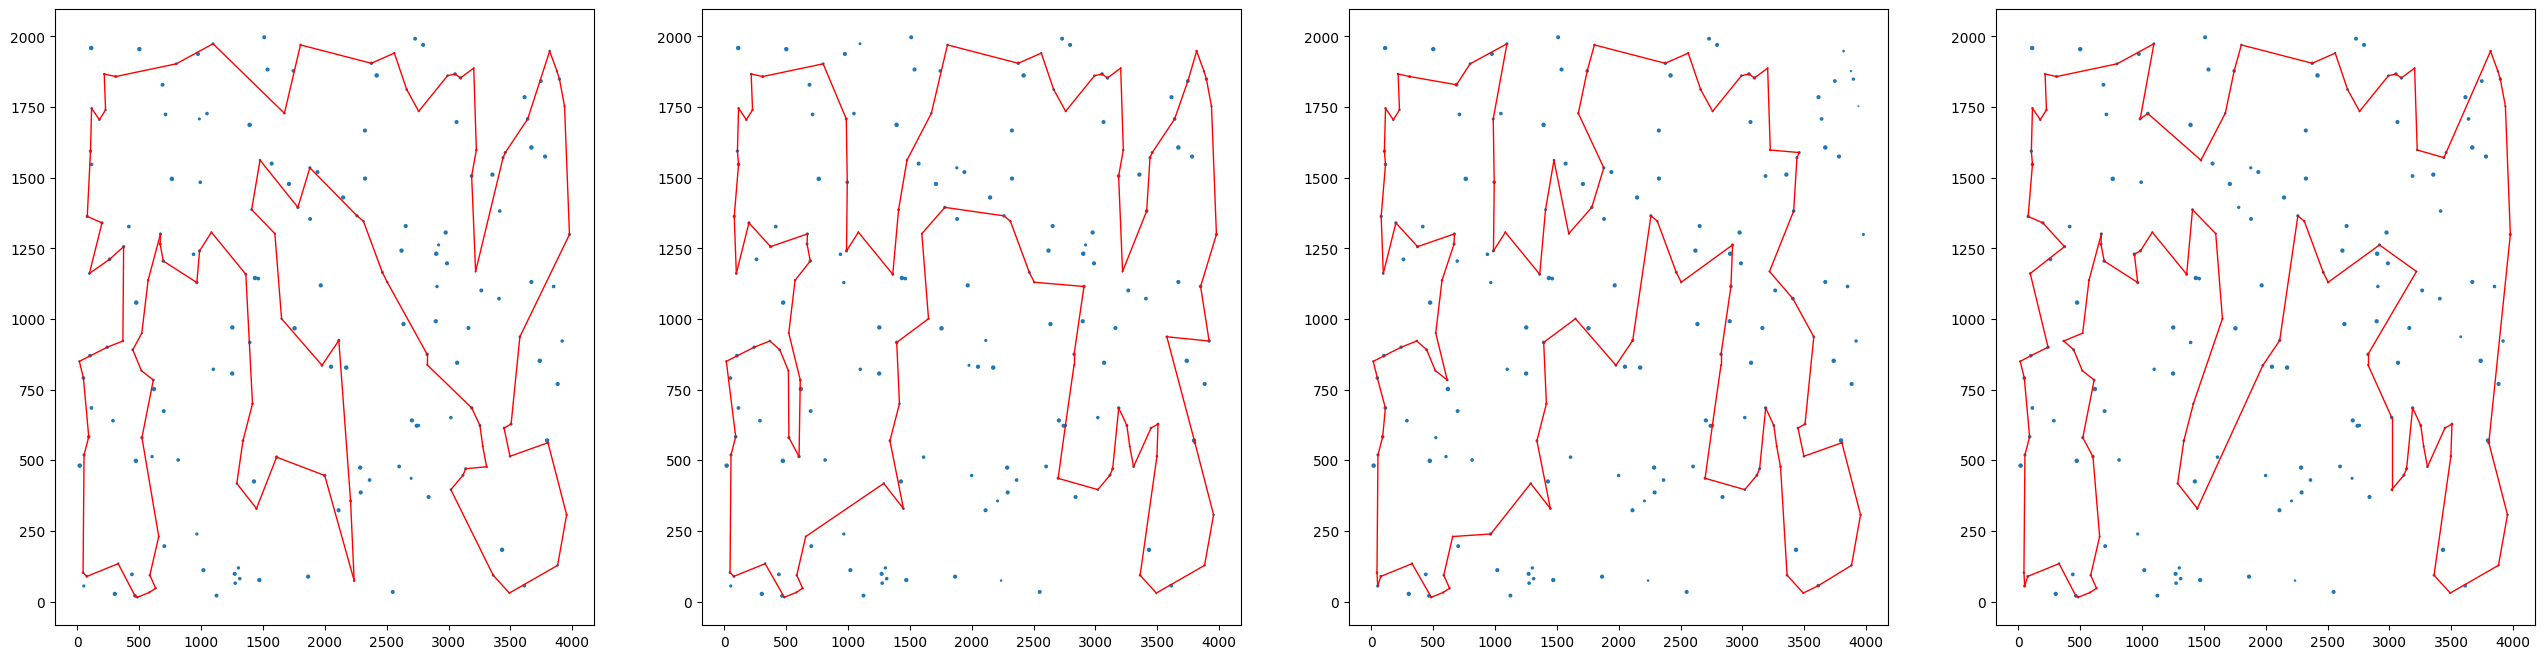

In [19]:
tspd.plot(d_previous_best_solutions + d_best_solution)

In [20]:
with open('results_d.json', 'w', encoding='utf-8') as f:
    json.dump(d_results, f, ensure_ascii=False, indent=4)
with open('best_solutions_d.json', 'w', encoding='utf-8') as f:
    json.dump(d_best_solution, f, ensure_ascii=False, indent=4)

---

## Conclusions

There is a difference in the performance of the evolutionary algorithm in comparison to other (most advanced) methods that were used between the instances.

In instance C, the evolutionary algorithm performed worse than large-scale search (taking into account the best obtained solution) but better than multiple-start local search and iterated local search. What is interesting is that the average result of the large-scale search and evolutionary algorithm is very similar; the worst result of 20 is much worse. The biggest difference between those two algorithms is the variability of the obtained solutions. The final population of the evolutionary algorithm is pretty dense.

In instance D, a similar conclusion can be drawn. However, for this instance, the evolutionary algorithm significantly outperformed other algorithms with respect to all metrics.

What is also visible from the scatter plots with results is that there is a little variability in the final population. We suspect that with greater variability, we could expect better results when it comes to the best-obtained solution as the evolution could cover a greater landscape of solutions. The simple solution for introducing more variability would be to include some kind of mutation in the algorithm.

Keeping in mind that the size of the population was rather small (only 20 solutions), we could consider the evolutionary algorithm to be a rather better meta-heuristic than other considered ones. However, it's also worth mentioning that there are a lot of parameters that could be tuned when it comes to the evolutionary algorithm (population size, way of choosing parents, enabling mutation, other corssover techniques).